In [2]:
!git clone https://jadelee@github.com/hanb0i/Basic-PiNN-Model-For-Three-Layered-Collision.git


Cloning into 'Basic-PiNN-Model-For-Three-Layered-Collision'...
remote: Enumerating objects: 228, done.
remote: Counting objects: 100% (228/228), done.
remote: Compressing objects: 100% (178/178), done.
remote: Total 228 (delta 65), reused 189 (delta 29), pack-reused 0 (from 0)
Receiving objects: 100% (228/228), 6.42 MiB | 33.38 MiB/s, done.
Resolving deltas: 100% (65/65), done.


In [3]:
import os, sys
from pathlib import Path

repo_root = Path('/content/Basic-PiNN-Model-For-Three-Layered-Collision')
pinn_dir = repo_root / 'pinn-workflow'
sys.path.insert(0, str(pinn_dir))
os.chdir(pinn_dir)


In [4]:

import torch
import torch.optim as optim
import numpy as np
import time
import os

import pinn_config as config
import data
import model
import physics
import matplotlib.pyplot as plt

def train():
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available():
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print(f"Using device: {device}")
    
    # Initialize Model
    pinn = model.MultiLayerPINN().to(device)
    
    # Initialize Optimizers
    optimizer_adam = optim.Adam(pinn.parameters(), lr=config.LEARNING_RATE)
    
    # Data Container
    training_data = data.get_data()
    
    # History
    loss_history = []
    
    print("Starting Adam Training...")
    start_time = time.time()
    last_time = start_time
    
    for epoch in range(config.EPOCHS_ADAM):
        optimizer_adam.zero_grad()
        
        # Periodic data refresh (optional, computationally expensive to re-sample every Step)
        if epoch % 1000 == 0 and epoch > 0:
            training_data = data.get_data()
            
        loss_val, losses = physics.compute_loss(pinn, training_data, device)
        loss_val.backward()
        optimizer_adam.step()
        
        loss_history.append(loss_val.item())
        
        if epoch % 100 == 0:
            current_time = time.time()
            step_duration = current_time - last_time
            last_time = current_time
            print(f"Epoch {epoch}: Total Loss: {loss_val.item():.6f} | "
                  f"PDE: {losses['pde']:.6f} | BC: {losses['bc_sides']:.6f} | "
                  f"Load: {losses['load']:.6f} | Interface: {losses['interface']:.6f} | "
                  f"Time: {step_duration:.4f}s")
            
    print(f"Adam Training Complete. Total Time: {time.time() - start_time:.2f}s")
    
    # L-BFGS Training
    print("Starting L-BFGS Training...")
    optimizer_lbfgs = optim.LBFGS(pinn.parameters(), 
                                  max_iter=100, 
                                  history_size=50, 
                                  line_search_fn="strong_wolfe")
    
    def closure():
        optimizer_lbfgs.zero_grad()
        loss_val, _ = physics.compute_loss(pinn, training_data, device)
        loss_val.backward()
        return loss_val
        
    num_lbfgs_steps = config.EPOCHS_LBFGS // 20
    print(f"Running {num_lbfgs_steps} L-BFGS outer steps.")
    
    for i in range(num_lbfgs_steps): 
        step_start = time.time()
        loss_val = optimizer_lbfgs.step(closure)
        step_end = time.time()
        loss_history.append(loss_val.item())
        
        # Print every step to see progress since total steps is small (5)
        print(f"L-BFGS Step {i}: Loss: {loss_val.item():.6f} | Time: {step_end - step_start:.4f}s")
            
    # Save Model
    torch.save(pinn.state_dict(), "pinn_model.pth")
    np.save("loss_history.npy", np.array(loss_history))
    print("Model saved.")
    return pinn

if __name__ == "__main__":
    train()


Using device: cuda
Starting Adam Training...
Epoch 0: Total Loss: 113.568642 | PDE: 10.586501 | BC: 0.000000 | Load: 0.004132 | Interface: 0.035430 | Time: 1.2240s
Epoch 100: Total Loss: 0.032980 | PDE: 0.002276 | BC: 0.000000 | Load: 0.000008 | Interface: 0.000015 | Time: 40.8022s
Epoch 200: Total Loss: 0.021327 | PDE: 0.001317 | BC: 0.000000 | Load: 0.000006 | Interface: 0.000006 | Time: 40.4025s
Epoch 300: Total Loss: 0.017799 | PDE: 0.000991 | BC: 0.000000 | Load: 0.000006 | Interface: 0.000005 | Time: 40.6885s
Epoch 400: Total Loss: 0.016174 | PDE: 0.000838 | BC: 0.000000 | Load: 0.000006 | Interface: 0.000004 | Time: 40.8826s
Adam Training Complete. Total Time: 204.56s
Starting L-BFGS Training...
Running 50 L-BFGS outer steps.
L-BFGS Step 0: Loss: 0.015259 | Time: 44.1928s
L-BFGS Step 1: Loss: 0.012807 | Time: 43.4229s
L-BFGS Step 2: Loss: 0.012073 | Time: 44.3683s
L-BFGS Step 3: Loss: 0.011730 | Time: 43.1656s
L-BFGS Step 4: Loss: 0.011560 | Time: 43.1347s
L-BFGS Step 5: Loss: 0

In [9]:
!pwd
!ls


/content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
cross_section.png     loss_curve.png	physics.py	plot.py      train.py
data.py		      loss_history.npy	pinn_config.py	__pycache__
displacement_top.png  model.py		pinn_model.pth	README.md


In [10]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision
!ls


/content/Basic-PiNN-Model-For-Three-Layered-Collision
benchmark_fea.py    fea-workflow      pinn_model.pth  __pycache__
compare_results.py  loss_history.npy  pinn-workflow   pyproject.toml


In [11]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
!python plot.py


/content/Basic-PiNN-Model-For-Three-Layered-Collision/pinn-workflow
Saved loss_curve.png
Saved displacement_top.png
Saved cross_section.png


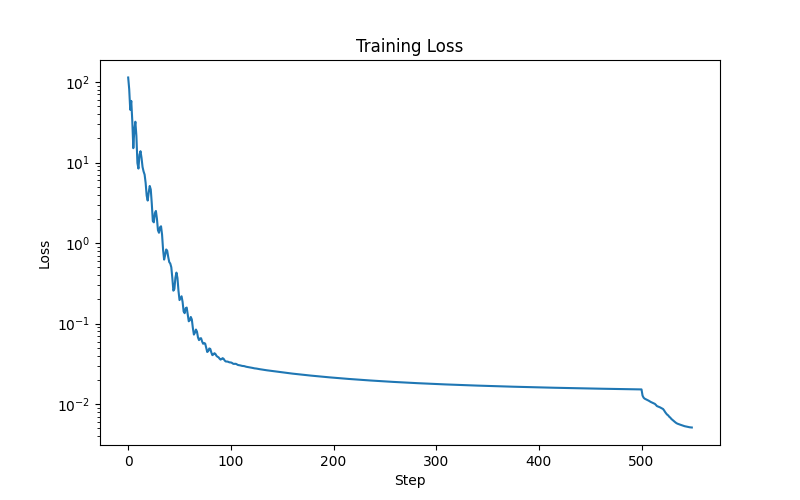

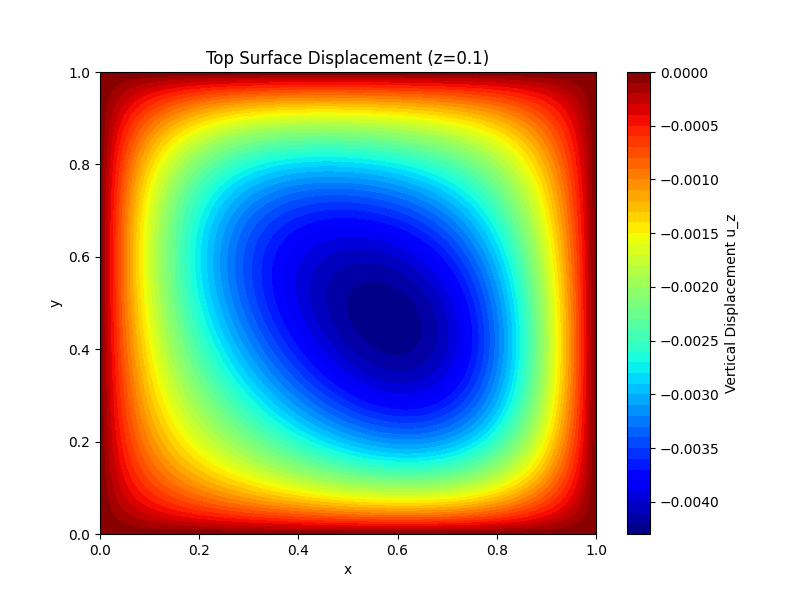

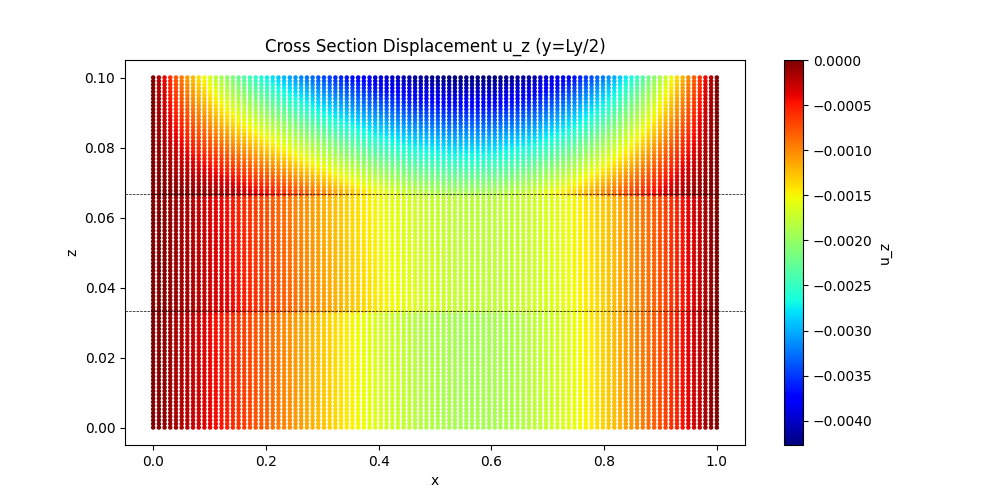

In [12]:
from IPython.display import Image, display

display(Image("loss_curve.png"))
display(Image("displacement_top.png"))
display(Image("cross_section.png"))


In [13]:
%cd

/root


In [14]:
%cd /content/Basic-PiNN-Model-For-Three-Layered-Collision

/content/Basic-PiNN-Model-For-Three-Layered-Collision


In [19]:
!python compare_results.py

Traceback (most recent call last):
  File "/content/Basic-PiNN-Model-For-Three-Layered-Collision/compare_results.py", line 8, in <module>
    import config
ModuleNotFoundError: No module named 'config'


In [16]:
compare_dir = repo_root 
sys.path.insert(0, str(compare_dir))
os.chdir(compare_dir)
